In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import h5py
import scipy
import skimage
from PIL import Image
from scipy import ndimage

In [2]:
# Import the dataset

train_dataset=h5py.File('train_catvnoncat.h5','r')
test_dataset=h5py.File('test_catvnoncat.h5','r')

In [3]:
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_set_x=np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y=np.array(test_dataset["test_set_y"][:]) # test set labels

train_set_y=train_set_y_orig.reshape(1,train_set_y_orig.shape[0])
test_set_y=test_set_y.reshape(1,test_set_y.shape[0])

classes = np.array(train_dataset["list_classes"][:]) # the list of classes (cat/non-cat)

y = [1], it's a 'cat' picture.


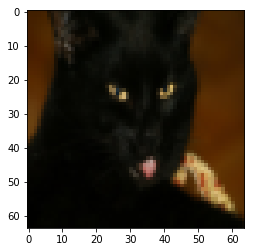

In [4]:
# Example of a picture
index = 38
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [5]:
# Reshaping the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0],-1).T

In [6]:
# Standardizing the dataset
# To standardize the image dataset just divide the dataset by the maximum pixel value 

train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255

In [7]:
# Sigmoid function as the activation function

def sigmoid(z):
    # z - A scalar or numpy array of any size.
    
    s=1/(1+np.exp(-z))
    return s

In [8]:
# This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0

def initialize_with_zeros(dim):
    # dim - size of the w vector we want (or number of parameters in this case)
    
    w = np.zeros([dim,1])
    b = 0
    return w,b

In [9]:
# Forward and Backward Propogation
# Implementing the cost function and its gradient

def propagate(w,b,X,Y):
    # w - weights, a numpy array of size (num_px * num_px * 3, 1)
    # b - bias, a scalar
    # X - data of size (num_px * num_px * 3, number of examples)
    # Y - true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)
    
    m = X.shape[1]
    # Forward Propogation(From X to Cost)
    A = sigmoid(np.dot(w.T,X)+b)                                # compute activation
    cost = -1/m*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)))         # compute cost
    
    # Backward Propogation(To find Grad)
    dw = 1/m*np.dot(X,(A-Y).T)                                  # gradient of the loss with respect to w
    db = 1/m*np.sum(A-Y)                                        # gradient of the loss with respect to b
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [10]:
# This function optimizes w and b by running a gradient descent algorithm

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost):
    # w - weights, a numpy array of size (num_px * num_px * 3, 1)
    # b - bias, a scalar
    # X - data of shape (num_px * num_px * 3, number of examples)
    # Y - true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    # num_iterations - number of iterations of the optimization loop
    # learning_rate - learning rate of the gradient descent update rule
    # print_cost - True to print the loss every 100 steps
    
    costs = []                            #list of all the costs computed during the optimization
    for i in range(num_iterations):
        grads, cost = propagate(w,b,X,Y)
        
        dw = grads["dw"]
        db = grads["db"]
        
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}                    # dictionary containing the weights w and bias b
    
    grads = {"dw": dw,
             "db": db}                   # dictionary containing the gradients of the weights and bias with respect to the cost function
    
    return params, grads, costs          

In [11]:
# Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

def predict(w, b, X):
    # w - weights, a numpy array of size (num_px * num_px * 3, 1)
    # b - bias, a scalar
    # X - data of size (num_px * num_px * 3, number of examples)

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T,X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i]>0.5:
            Y_prediction[0,i]=1
        else:
            Y_prediction[0,i]=0
    
    return Y_prediction        # a numpy array (vector) containing all predictions (0/1) for the examples in X

In [12]:
# Builds the logistic regression model by calling the function

def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost):
    # X_train - training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    # Y_train - training labels represented by a numpy array (vector) of shape (1, m_train)
    # X_test - test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    # Y_test - test labels represented by a numpy array (vector) of shape (1, m_test)
    # num_iterations - hyperparameter representing the number of iterations to optimize the parameters
    # learning_rate - hyperparameter representing the learning rate used in the update rule of optimize()
    # print_cost - Set to true to print the cost every 100 iterations
    
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w,b,X_train,Y_train,num_iterations,learning_rate,print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d                  # dictionary containing information about the model.

In [13]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


y = 1.0, your algorithm predicts a "cat" picture.


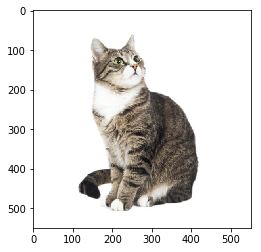

In [17]:
# Testing with a random image with true positive

fname=r"C:\Users\DELL\Downloads\cat.jpg"

# Preprocessing the image to fit our algorithm.
num_px=64
image = np.array(matplotlib.pyplot.imread(fname))       # Reads an image from a file into an array.
image = image/255
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


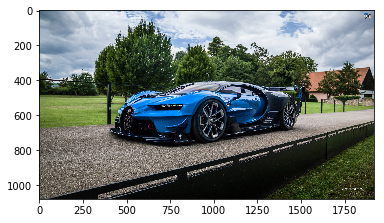

In [15]:
# Testing with a random image with true negative

fname=r"C:\Users\DELL\Downloads\bugatti.jpg"

# Preprocessing the image to fit our algorithm.
num_px=64
image = np.array(matplotlib.pyplot.imread(fname))       # Reads an image from a file into an array.
image = image/255
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 0.0, your algorithm predicts a "non-cat" picture.


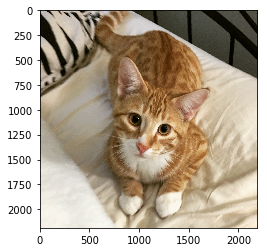

In [16]:
# Testing with a random image with false negative

fname=r"C:\Users\DELL\Downloads\cat1.jpg"

# Preprocessing the image to fit our algorithm.
num_px=64
image = np.array(matplotlib.pyplot.imread(fname))       # Reads an image from a file into an array.
image = image/255
my_image = skimage.transform.resize(image, output_shape=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(d["w"], d["b"], my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")